## Machine Learning Project: Photometric Redshift

In [1]:
import numpy as np
import matplotlib.pyplot as plt 
import pandas as pd
import os
import PIL
import re
from tqdm.notebook import tqdm
from sklearn.model_selection import train_test_split
from tensorflow.keras import layers, models, activations, metrics, optimizers, losses, utils, preprocessing
from tensorflow.keras.preprocessing.image import load_img, img_to_array

2022-01-06 23:13:10.555105: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-01-06 23:13:10.555128: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


First, lets get familiar with the dataset here, look at the dimensions of the images (without reading them in)

In [2]:
SOURCE_DIR = "photoz_images/"
imgs = [PIL.Image.open(SOURCE_DIR+filename).size for filename in os.listdir(SOURCE_DIR)]

# see how many images of which size we have
sizes, counts = np.unique(imgs, axis=0, return_counts=True)
sizes, counts

(array([[72, 72]]), array([57720]))

As all images are of the same size, we won't need heavy preprosessing, as we can use the original size, since 72x72 is quite handable. (Let's hope I don't regret saying that later)

In [3]:
RE = re.compile(r"^(?P<ID>\d+)_z_(?P<redshift>\d+\.\d*(e-\d+)?).jpg$")
def load_image(source_dir, filename):
    img = img_to_array(load_img(source_dir+filename), dtype=np.float16)/255
    matches = RE.match(filename)
    return img, float(matches.group("redshift"))

In [4]:
dirlist = list(os.listdir(SOURCE_DIR))
images = np.empty((len(dirlist), 72, 72, 3), np.float16)
redshifts = np.empty((len(dirlist),), np.float32)
for idx, filename in enumerate(tqdm(dirlist)):
    image, redshift = load_image(SOURCE_DIR, filename)
    images[idx] = image
    redshifts[idx] = redshift

  0%|          | 0/57720 [00:00<?, ?it/s]

In [5]:
# Approach: first prepare train and test dataset. For each trained model
# split a portion of the training dataset to use as validation to find good hyperparams
# For keras we will use the build-in validation split, and for sklearn we can use k-fold
X_train, X_test, y_train, y_test = train_test_split(images, redshifts, train_size=0.95)
X_train.shape

(54834, 72, 72, 3)

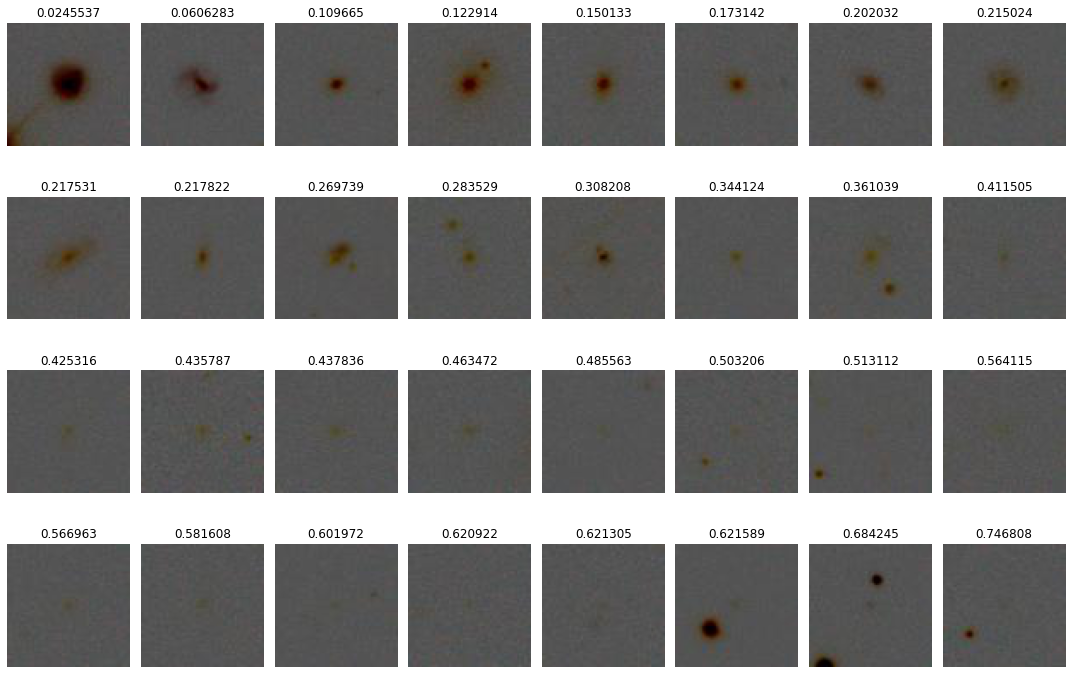

In [6]:
# Look at some (randomly chosen) images 
# ordered to high redshift values to make some sense of it

def plot_images(X, y, M=4, N=8):
    plt.figure(figsize=(15, 10))
    mask = np.arange(y.shape[0])
    np.random.shuffle(mask)
    mask = mask[:M*N]
    mask = mask[np.argsort(y[mask])]
    for i in range(M*N):
        ax = plt.subplot(M, N, i + 1)
        plt.imshow(X[mask][i].astype("float64"))
        plt.title(y[mask][i])
        plt.axis("off")
    plt.tight_layout()

plot_images(X_train, y_train, 4, 8)

In [7]:
# split some validation data: 
X_train_, X_val, y_train_, y_val = train_test_split(X_train, y_train, train_size=0.95)
X_train_.shape

(52092, 72, 72, 3)

Next, lets do a PCA to get a better feel for what features in the pictures are important.

In [8]:
from sklearn.decomposition import PCA

In [9]:
pca = PCA(n_components=10)
X_train_flat = X_train_.reshape(X_train_.shape[0], X_train_.shape[1]*X_train_.shape[2]*X_train_.shape[3])
pca = pca.fit(X_train_flat)

In [10]:
components_train = pca.transform(X_train_flat)
projected = pca.inverse_transform(components_train)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


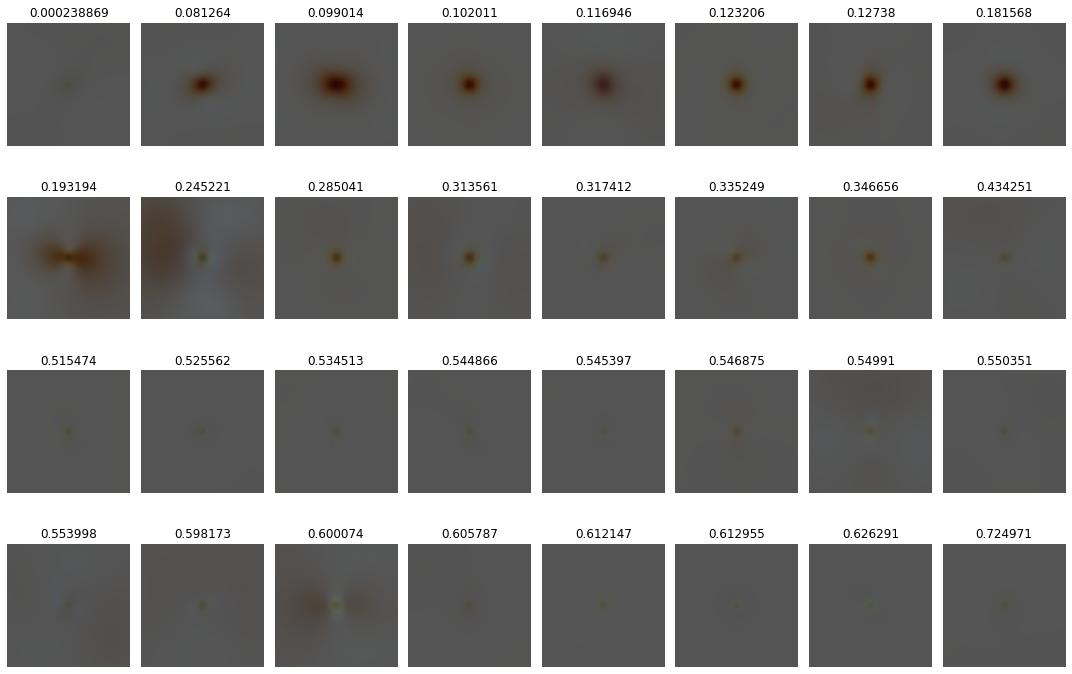

In [11]:
plot_images(projected.reshape(X_train_.shape[0], 72, 72, 3), y_train_)

As expected: The pictures seem blured, but the color is still very much the same, so this seems to be important. Maybe we will make later use of the PCA, but first start with the first model: A convolutional neural net.

In [12]:
# Our first model: classic CNN architecture
model = models.Sequential()

model.add(layers.Conv2D(16, (2, 2), activation=activations.swish, input_shape=(72, 72, 3)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Dropout(0.5))

model.add(layers.Conv2D(32, (2, 2), activation=activations.swish))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Dropout(0.5))

model.add(layers.Conv2D(64, (3, 3), activation=activations.swish))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Dropout(0.5))

model.add(layers.Flatten())

model.add(layers.Dense(60, activation=activations.swish))
model.add(layers.Dropout(0.5))

model.add(layers.Dense(60, activation=activations.swish))
model.add(layers.Dropout(0.5))

model.add(layers.Dense(60, activation=activations.swish))
model.add(layers.Dropout(0.5))

model.add(layers.Dense(1, activation=activations.relu))

2022-01-06 23:17:17.331093: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2022-01-06 23:17:17.331499: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2022-01-06 23:17:17.332373: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (mobile): /proc/driver/nvidia/version does not exist
2022-01-06 23:17:17.338809: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [13]:
model.compile(optimizer=optimizers.Adam(learning_rate=1e-3),
              loss=losses.MeanSquaredError(),
              metrics=[metrics.MeanAbsoluteError(), metrics.RootMeanSquaredError()])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 71, 71, 16)        208       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 35, 35, 16)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 35, 35, 16)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 34, 34, 32)        2080      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 17, 17, 32)       0         
 2D)                                                             
                                                                 
 dropout_1 (Dropout)         (None, 17, 17, 32)        0

The exact architecture of the Neural Net was determined by building the model and testing it on the validation dataset.

In [14]:
history = model.fit(x=X_train_, y=y_train_, epochs=10, batch_size=32, validation_data=(X_val, y_val), use_multiprocessing=True)

2022-01-06 23:17:30.613327: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 3240539136 exceeds 10% of free system memory.


Epoch 1/10
1628/1628 [==============================] - 75s 46ms/step - loss: 0.0176 - mean_absolute_error: 0.0969 - root_mean_squared_error: 0.1327 - val_loss: 0.0105 - val_mean_absolute_error: 0.0712 - val_root_mean_squared_error: 0.1024
Epoch 2/10
1628/1628 [==============================] - 73s 45ms/step - loss: 0.0118 - mean_absolute_error: 0.0776 - root_mean_squared_error: 0.1087 - val_loss: 0.0095 - val_mean_absolute_error: 0.0672 - val_root_mean_squared_error: 0.0977
Epoch 3/10
1628/1628 [==============================] - 73s 45ms/step - loss: 0.0102 - mean_absolute_error: 0.0686 - root_mean_squared_error: 0.1008 - val_loss: 0.0103 - val_mean_absolute_error: 0.0669 - val_root_mean_squared_error: 0.1015
Epoch 4/10
1628/1628 [==============================] - 74s 45ms/step - loss: 0.0095 - mean_absolute_error: 0.0651 - root_mean_squared_error: 0.0973 - val_loss: 0.0131 - val_mean_absolute_error: 0.0791 - val_root_mean_squared_error: 0.1143
Epoch 5/10
1628/1628 [==================

The number of epochs was chosen to be 10 after testing on the validation dataset: the Score stayed mostly constant on the validation dataset after 10 rounds.

In [15]:
y_pred_val = model.predict(X_val, use_multiprocessing=True)

In [16]:
from sklearn.metrics import mean_squared_error

def plot_prediction_vis(y, y_pred):
    plt.xlabel("True Redshift")
    plt.ylabel("Predicted Redshift")
    plt.scatter(y, y_pred, label="performance", alpha=0.1)
    plt.plot([0, 1], [0, 1], label="optimal", color="red")
    plt.legend()
    rme = mean_squared_error(y, y_pred, squared=False)
    plt.title(f"RME={rme:.2}")
    plt.tight_layout()
    
def plot_history(history):
    plt.xlabel("Epoch")
    plt.ylabel("RMS")
    plt.plot(history["root_mean_squared_error"], label="Training")
    plt.plot(history["val_root_mean_squared_error"], label="Validation")
    plt.legend()
    plt.tight_layout()

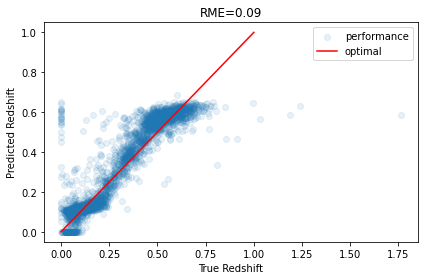

In [17]:
plot_prediction_vis(y_val, y_pred_val)

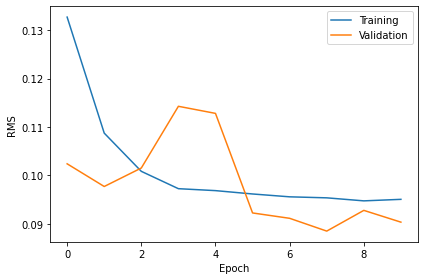

In [18]:
plot_history(history.history)

It is a weird effect that the validation dataset performs better than the training dataset, normally that should be the other way around.

In some training rounds there seems to be a weird effect (as sometimes seen from the plot two cells above): The neural network only (mostly) predicts values between ca. 0.1 and 0.5. This is weird since the last activation function of the network is relu, which should be able to output everything greater than 0. 
Note that is more common for the last activation function to be just linear, but since we now the redshift ist bigger than 0, we can use relu.
We could not find the source of that, but sometimes the effect does not appear at all.

(0.0, 0.68382317)

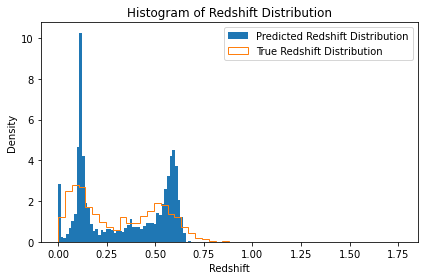

In [19]:
# visualising the predicted Redshift vs True Redshift distribution 
# to help understand why the prediction seems to be restricted to an interval
plt.hist(y_pred_val, bins=50, density=True, label="Predicted Redshift Distribution")
plt.hist(y_val, bins=50, histtype="step", density=True, label="True Redshift Distribution")
plt.legend()
plt.xlabel("Redshift")
plt.ylabel("Density")
plt.title("Histogram of Redshift Distribution")
plt.tight_layout()
np.min(y_pred_val), np.max(y_pred_val)

Onto the next 2 classifiers: RandomForest classifier and SVM
Since they are not build for handling $72\cdot72\cdot3=15552$ input features, we have to reduce the dimensionality. 

I will only use the first 10 principle components, as determined earlier by PCA. This may not be the fairest comparison to the neural net, but it serves as a starting point. Another technique might be passing the data only throught the convolutional layers and thus combining the models.

In [20]:
from sklearn.ensemble import RandomForestRegressor

In [21]:
rf = RandomForestRegressor(n_estimators=32, verbose=11, n_jobs=-1)
rf.fit(components_train, y_train_)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 16 concurrent workers.


building tree 1 of 32
building tree 2 of 32
building tree 3 of 32
building tree 4 of 32
building tree 5 of 32
building tree 6 of 32
building tree 7 of 32building tree 8 of 32
building tree 9 of 32

building tree 10 of 32
building tree 11 of 32
building tree 12 of 32
building tree 13 of 32
building tree 14 of 32
building tree 15 of 32
building tree 16 of 32


[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    0.9s
[Parallel(n_jobs=-1)]: Done   4 out of  32 | elapsed:    1.0s remaining:    6.8s
[Parallel(n_jobs=-1)]: Done   7 out of  32 | elapsed:    1.0s remaining:    3.5s
[Parallel(n_jobs=-1)]: Done  10 out of  32 | elapsed:    1.0s remaining:    2.2s
[Parallel(n_jobs=-1)]: Done  13 out of  32 | elapsed:    1.1s remaining:    1.5s
[Parallel(n_jobs=-1)]: Done  16 out of  32 | elapsed:    1.1s remaining:    1.1s


building tree 17 of 32
building tree 18 of 32
building tree 19 of 32
building tree 20 of 32
building tree 21 of 32
building tree 22 of 32
building tree 23 of 32
building tree 24 of 32building tree 25 of 32

building tree 26 of 32
building tree 27 of 32
building tree 28 of 32
building tree 29 of 32
building tree 30 of 32
building tree 31 of 32
building tree 32 of 32


[Parallel(n_jobs=-1)]: Done  19 out of  32 | elapsed:    1.9s remaining:    1.3s
[Parallel(n_jobs=-1)]: Done  22 out of  32 | elapsed:    1.9s remaining:    0.9s
[Parallel(n_jobs=-1)]: Done  25 out of  32 | elapsed:    1.9s remaining:    0.5s
[Parallel(n_jobs=-1)]: Done  28 out of  32 | elapsed:    2.0s remaining:    0.3s
[Parallel(n_jobs=-1)]: Done  32 out of  32 | elapsed:    2.0s finished


RandomForestRegressor(n_estimators=32, n_jobs=-1, verbose=11)

In [22]:
X_val_flat = X_val.reshape(X_val.shape[0], X_val.shape[1]*X_val.shape[2]*X_val.shape[3])
components_val = pca.transform(X_val_flat)
y_rf_pred = rf.predict(components_val) 

[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done   1 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done   4 out of  32 | elapsed:    0.0s remaining:    0.3s
[Parallel(n_jobs=16)]: Done   7 out of  32 | elapsed:    0.0s remaining:    0.2s
[Parallel(n_jobs=16)]: Done  10 out of  32 | elapsed:    0.0s remaining:    0.1s
[Parallel(n_jobs=16)]: Done  13 out of  32 | elapsed:    0.0s remaining:    0.1s
[Parallel(n_jobs=16)]: Done  16 out of  32 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=16)]: Done  19 out of  32 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=16)]: Done  22 out of  32 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=16)]: Done  25 out of  32 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=16)]: Done  28 out of  32 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=16)]: Done  32 out of  32 | elapsed:    0.0s finished


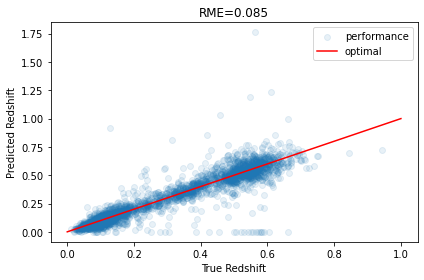

In [23]:
plot_prediction_vis(y_rf_pred, y_val)

The Random Forest works increadibly well compared to the Neural Net, and that with only 10 features of the PCA. The most important hyperparameter, the number of trees in the forest was determined by evaluating on the validation dataset. After a given number of trees, it did not make a difference to add more trees, so a lower number than 100 was chosen. The other hyperparameters did not make as much of a difference.

In [24]:
from sklearn.svm import SVR
svm = SVR(C=1, kernel='rbf', verbose=1, max_iter=1e6)

In [25]:
svm.fit(components_train, y_train_, )

[LibSVM].......
*....*
optimization finished, #iter = 11736
obj = -411.322959, rho = -0.199994
nSV = 4916, nBSV = 4163


SVR(C=1, max_iter=1000000.0, verbose=1)

In [26]:
y_svm_pred = svm.predict(components_val) 

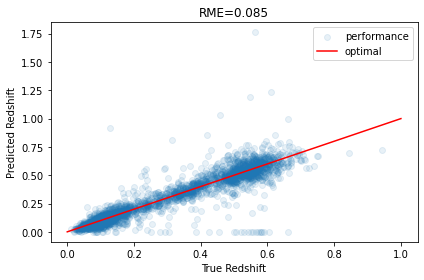

In [27]:
plot_prediction_vis(y_rf_pred, y_val)

There are not a lot of hyperparameters with a source vector machine to determin. The most important one being the kernel function, all kernels gave a very similar outcome, so we will stick with the radial basis function 'rbf'.

Regularization here is done on default with L2 regularization parameter. 

### Comparing the 3 models on the test dataset

In [28]:
X_test_flat = X_test.reshape(X_test.shape[0], X_test.shape[1]*X_test.shape[2]*X_test.shape[3])
components_test = pca.transform(X_test_flat)

[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done   1 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done   4 out of  32 | elapsed:    0.0s remaining:    0.1s
[Parallel(n_jobs=16)]: Done   7 out of  32 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=16)]: Done  10 out of  32 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=16)]: Done  13 out of  32 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=16)]: Done  16 out of  32 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=16)]: Done  19 out of  32 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=16)]: Done  22 out of  32 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=16)]: Done  25 out of  32 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=16)]: Done  28 out of  32 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=16)]: Done  32 out of  32 | elapsed:    0.0s finished


Score of CNN: 0.0919
Score of RF: 0.0866
Score of SVM: 0.0868


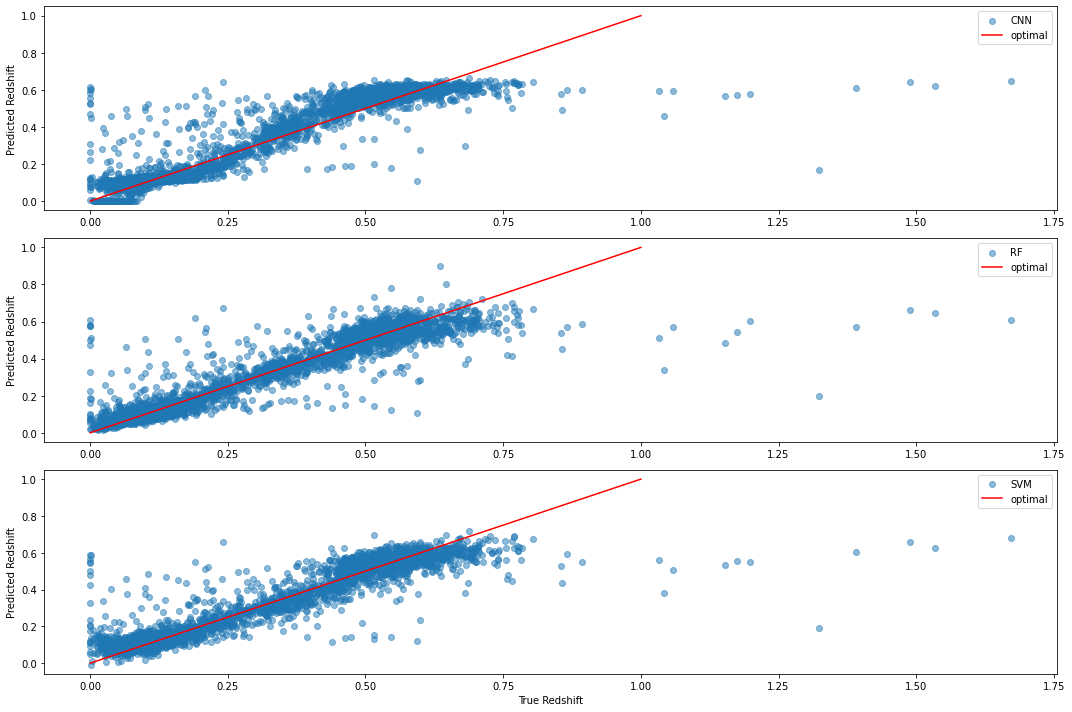

In [29]:
y_test_pred_nn = model.predict(X_test)
y_test_pred_rf = rf.predict(components_test)
y_test_pred_svm = svm.predict(components_test)

rme_nn = mean_squared_error(y_test, y_test_pred_nn, squared=False)
rme_rf = mean_squared_error(y_test, y_test_pred_rf, squared=False)
rme_svm = mean_squared_error(y_test, y_test_pred_svm, squared=False)
print(f"Score of CNN: {rme_nn:.3}")
print(f"Score of RF: {rme_rf:.3}")
print(f"Score of SVM: {rme_svm:.3}")


plt.figure(figsize=(15, 10))
ax = plt.subplot(3, 1, 1)
plt.scatter(y_test, y_test_pred_nn, label="CNN", alpha=0.5)
plt.plot([0, 1], [0, 1], label="optimal", color="red")
plt.legend()
plt.ylabel("Predicted Redshift")


ax = plt.subplot(3, 1, 2)
plt.scatter(y_test, y_test_pred_rf, label="RF", alpha=0.5)
plt.plot([0, 1], [0, 1], label="optimal", color="red")
plt.legend()
plt.ylabel("Predicted Redshift")


ax = plt.subplot(3, 1, 3)
plt.scatter(y_test, y_test_pred_svm, label="SVM", alpha=0.5)
plt.plot([0, 1], [0, 1], label="optimal", color="red")
plt.legend()

plt.xlabel("True Redshift")
plt.ylabel("Predicted Redshift")

plt.tight_layout()

With this comparison on the test dataset we see, that the support vector machine and the random forest outperform the convolutional neural net. This is very suprising.
This may hint at some systematic error regarding the CNN, since CNNs generally are very powerful especially with images. 
This can also mean that the PCA is a very good and powerful tool on this dataset. 

Regularization in the Neural Network was done with Dropout regularization and for the SVM, standard L2 regularization was used. The random forest was not regularized, as there is no standard method to do this, but the design of an ensemble learner should provide enough help against overfitting anyway. 

All the hyperparameters were first tested and chosen on the validation dataset, the test dataset was only used in the very end, to analyse the performence of the models.